In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sentence_transformers import SentenceTransformer,util, SimilarityFunction
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
!pip install -U sentence-transformers
!pip install fuzzywuzzy

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
pd.set_option('display.max_colwidth',200)

In [ ]:
final_df=pd.read_csv('/content/final_semantic_dataset.csv')


In [ ]:
final_df=pd.read_csv('/content/merged_df.csv')

## Data Preprocessing

In [ ]:
def preprocessing(text):
  text = str(text).lower().strip()

  # Replace certain special characters with their string equivalents
  text = text.replace('%', ' percent')
  text = text.replace('$', ' dollar ')
  text = text.replace('₹', ' rupee ')
  text = text.replace('€', ' euro ')
  text = text.replace('@', ' at ')

  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }


  text_decontracted=[]
  for word in text.split():
    if word in contractions:
      word=contractions[word]
    text_decontracted.append(word)
  text=" ".join(text_decontracted)
  text=text.replace("'ve",'have')
  text=text.replace("n't",'not')
  text=text.replace("'re",'are')
  text=text.replace("'ll",'will')
  return text

# lowercasing and decontraction

In [ ]:
final_df['complaint-1']=final_df['complaint-1'].apply(preprocessing)
final_df['complaint-2']=final_df['complaint-2'].apply(preprocessing)

# removing `" "`

In [ ]:
final_df['complaint-1']=final_df['complaint-1'].str.replace('"','')
final_df['complaint-2']=final_df['complaint-2'].str.replace('"','')

# Removing stopwords and lemmatization

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

In [ ]:
def remove_stopwords(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  words = text.split()
  words=[lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  text=" ".join(words)
  return text

In [ ]:
final_df['processed_comp1']=final_df['complaint-1'].apply(remove_stopwords)
final_df['processed_comp2']=final_df['complaint-2'].apply(remove_stopwords)

In [ ]:
final_df

,complaint-1,complaint-2,semantic similarity,processed_comp1,processed_comp2
0,there is a lack of funding for students attending professional conferences and workshops.,student attendance at professional conferences and workshops is not well funded.,1,lack funding student attending professional conference workshop,student attendance professional conference workshop well funded
1,"as an athlete, i am frustrated with the limited access to athletic facilities during peak hours. it is difficult to fit in training sessions when the gym is always packed.","gender inequality in sports is a pervasive issue that affects all students, not just athletes. the university should do more to promote gender equity and empowerment.",0,athlete frustrated limited access athletic facility peak hour difficult fit training session gym always packed,gender inequality sport pervasive issue affect student athlete university promote gender equity empowerment
2,the university does not offer enough support for students interested in aerospace design and manufacturing.,insufficient assistance is provided by the institution to students who are interested in aircraft design and production.,1,university offer enough support student interested aerospace design manufacturing,insufficient assistance provided institution student interested aircraft design production
3,the lack of face-to-face interaction in online classes has made it difficult to engage with peers and build relationships with professors.,"it is challenging to maintain focus and avoid distractions during online classes, especially for students living in crowded or noisy environments.",0,lack facetoface interaction online class made difficult engage peer build relationship professor,challenging maintain focus avoid distraction online class especially student living crowded noisy environment
4,the food served in the canteen is often greasy and unhealthy.,the canteen does not provide enough options for students with dietary restrictions such as keto or paleo.,0,food served canteen often greasy unhealthy,canteen provide enough option student dietary restriction keto paleo
...,...,...,...,...,...
987,the fine arts instructor does not provide enough individual guidance on projects.,the telecommunication engineering professor does not provide enough lab sessions for practical learning.,0,fine art instructor provide enough individual guidance project,telecommunication engineering professor provide enough lab session practical learning
988,"i have been applying to job opportunities outside of my field of study in hopes of finding something, but it has been difficult to make any progress.","i wish there were more opportunities to connect with professionals outside of the university, like networking events or mentorship programs.",0,applying job opportunity outside field study hope finding something difficult make progress,wish opportunity connect professional outside university like networking event mentorship program
989,online classes can make it harder to balance academic responsibilities with work or family obligations.,it may be more difficult to juggle scholastic demands with job or family responsibilities when taking programs online.,1,online class make harder balance academic responsibility work family obligation,may difficult juggle scholastic demand job family responsibility taking program online
990,the limited access to research databases and materials is causing a lot of frustration for students. it is important that we have better access to complete our coursework.,students' discontent with the restricted access to research resources and materials is high. it is critical that we have improved access to do our schoolwork.,1,limited access research database material causing lot frustration student important better access complete coursework,student discontent restricted access research resource material high critical improved access schoolwork


# Text Embedding

In [ ]:
# Text embedding modal selection
# model=SentenceTransformer('all-MiniLM-L6-v2')
model=SentenceTransformer('all-mpnet-base-v2')
# model.similarity_fn_name = SimilarityFunction.MANHATTAN
# model.similarity_fn_name = SimilarityFunction.DOT_PRODUCT

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
model1=SentenceTransformer('sentence-transformers/LaBSE')

In [ ]:
emb1=model.encode(final_df['processed_comp1'].tolist(),convert_to_tensor=True)
emb2=model.encode(final_df['processed_comp2'].tolist(),convert_to_tensor=True)

In [ ]:
cos_sim=util.cos_sim(emb1,emb2)
# cos_sim=cos_sim.diagonal()
# cos_sim=model.similarity(emb1, emb2)
# cos_sim

In [ ]:

cos_sim=cos_sim.diagonal()

In [ ]:
final_df['cos_sim'] = cos_sim.cpu().numpy()


Text(0.5, 1.0, 'KDE of cosine similarity')

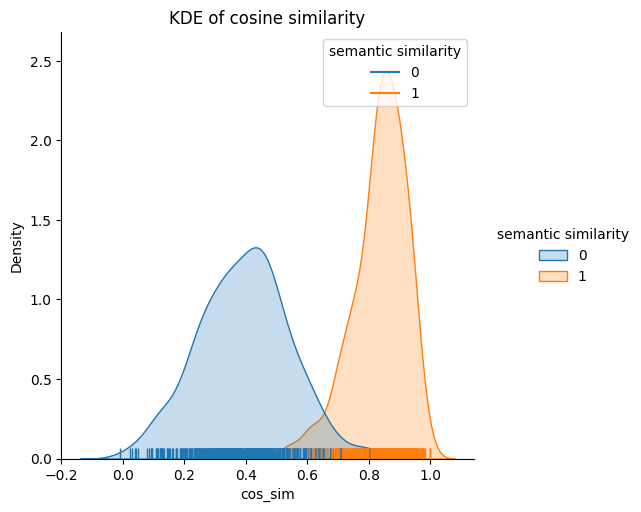

In [ ]:
sns.displot(data=final_df,x='cos_sim',hue='semantic similarity',kind='kde',fill=True)
sns.rugplot(data=final_df,x='cos_sim',hue='semantic similarity')
plt.title('KDE of cosine similarity')

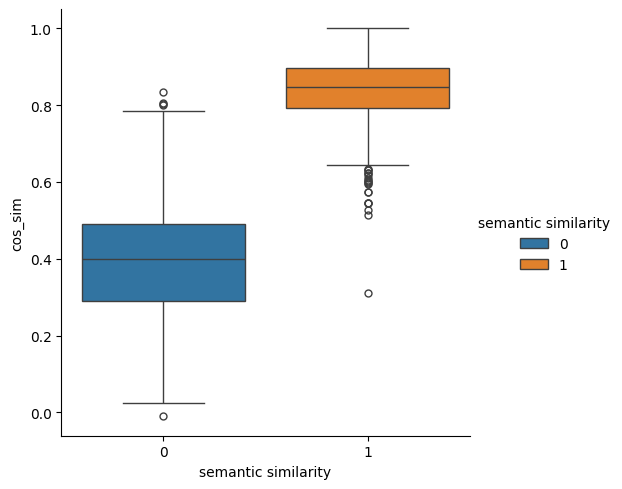

In [ ]:
sns.catplot(data=final_df,x='semantic similarity',y='cos_sim',kind='box',hue='semantic similarity')

In [ ]:
same=final_df[final_df['semantic similarity']==1]
diff=final_df[final_df['semantic similarity']==0]

In [ ]:
diff


,complaint-1,complaint-2,semantic similarity,processed_comp1,processed_comp2,cos_sim
1,"as an athlete, i am frustrated with the limited access to athletic facilities during peak hours. it is difficult to fit in training sessions when the gym is always packed.","gender inequality in sports is a pervasive issue that affects all students, not just athletes. the university should do more to promote gender equity and empowerment.",0,athlete frustrated limited access athletic facility peak hour difficult fit training session gym always packed,gender inequality sport pervasive issue affect student athlete university promote gender equity empowerment,0.319354
3,the lack of face-to-face interaction in online classes has made it difficult to engage with peers and build relationships with professors.,"it is challenging to maintain focus and avoid distractions during online classes, especially for students living in crowded or noisy environments.",0,lack facetoface interaction online class made difficult engage peer build relationship professor,challenging maintain focus avoid distraction online class especially student living crowded noisy environment,0.522505
4,the food served in the canteen is often greasy and unhealthy.,the canteen does not provide enough options for students with dietary restrictions such as keto or paleo.,0,food served canteen often greasy unhealthy,canteen provide enough option student dietary restriction keto paleo,0.488194
6,the campus lacks sufficient spaces for hosting large events.,the university does not offer enough support for students interested in public service.,0,campus lack sufficient space hosting large event,university offer enough support student interested public service,0.344417
7,finding job opportunities feels like a full-time job in itself. the university should do more to make this process easier for students.,i have found it challenging to find job opportunities that match my specific interests and career goals.,0,finding job opportunity feel like fulltime job university make process easier student,found challenging find job opportunity match specific interest career goal,0.437092
...,...,...,...,...,...,...
978,ihave had to move to a different city just to be able to afford housing and transportation costs.,"the housing market in this area is so competitive that i feel like i am constantly battling with other students to find a decent place to live. it is stressful and exhausting, and i wish there wer...",0,ihave move different city able afford housing transportation cost,housing market area competitive feel like constantly battling student find decent place live stressful exhausting wish option available u,0.518215
982,there is a lack of resources for students to develop digital literacy skills.,"the platform does not support group work effectively, making collaboration with peers challenging.",0,lack resource student develop digital literacy skill,platform support group work effectively making collaboration peer challenging,0.232946
983,there is a lack of transparency in the allocation of academic resources.,the university lacks sufficient online tutorials and instructional videos.,0,lack transparency allocation academic resource,university lack sufficient online tutorial instructional video,0.393367
987,the fine arts instructor does not provide enough individual guidance on projects.,the telecommunication engineering professor does not provide enough lab sessions for practical learning.,0,fine art instructor provide enough individual guidance project,telecommunication engineering professor provide enough lab session practical learning,0.418629


<Axes: ylabel='cos_sim'>

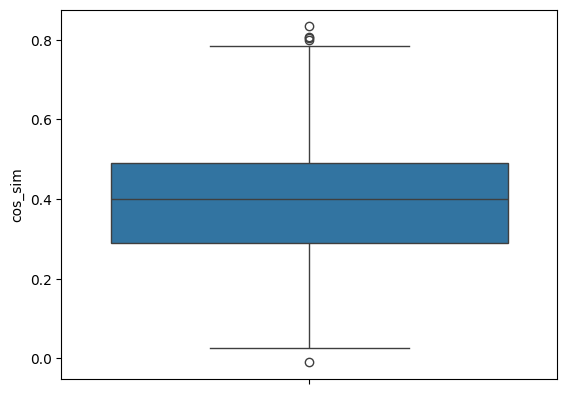

In [ ]:
sns.boxplot(data=diff['cos_sim'])

In [ ]:
diff['cos_sim'].describe()

,cos_sim
count,501.000000
mean,0.393968
std,0.148694
min,-0.010445
25%,0.290405
50%,0.400272
75%,0.489242
max,0.833837


In [ ]:
percentile25=diff['cos_sim'].quantile(0.25)
percentile75=diff['cos_sim'].quantile(0.75)

In [ ]:
iqr=percentile75-percentile25
iqr

0.19883644580841064

In [ ]:
upper_limit=percentile75+1.5*iqr
upper_limit

0.7874965369701385

In [ ]:
# finding-outliers
diff['cos_sim']=np.where(diff['cos_sim']>=upper_limit,upper_limit,diff['cos_sim'])

<ipython-input-29-e34f638dbcc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff['cos_sim']=np.where(diff['cos_sim']>=upper_limit,upper_limit,diff['cos_sim'])


<Axes: ylabel='cos_sim'>

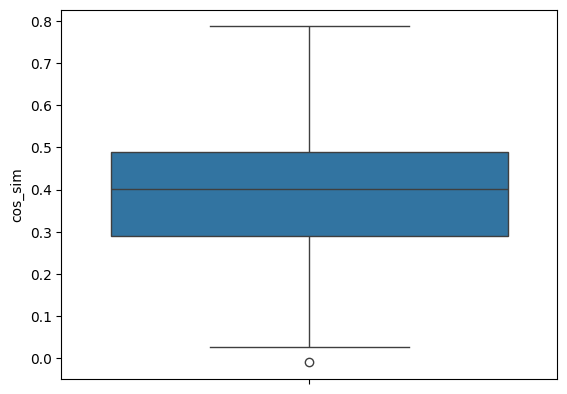

In [ ]:
sns.boxplot(data=diff['cos_sim'])

In [ ]:
same['cos_sim'].describe()

count    491.000000
mean       0.832615
std        0.091251
min        0.311862
25%        0.791681
50%        0.847174
75%        0.896251
max        1.000000
Name: cos_sim, dtype: float64

In [ ]:
percent25=same['cos_sim'].quantile(0.25)
percent75=same['cos_sim'].quantile(0.75)
iqr=percent75-percent25
iqr

0.10456976294517517

In [ ]:
lower_limit=percent25-1.5*iqr
lower_limit

0.6348262578248978

In [ ]:
same['cos_sim']=np.where(same['cos_sim']<lower_limit,lower_limit,same['cos_sim'])

<ipython-input-32-548f9d214c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same['cos_sim']=np.where(same['cos_sim']<lower_limit,lower_limit,same['cos_sim'])


In [ ]:
final_df=pd.concat([same,diff],ignore_index=True)
final_df.to_csv('final_after_outliers.csv',index=False)

Text(0.5, 1.0, 'BOX plot after removing outliers')

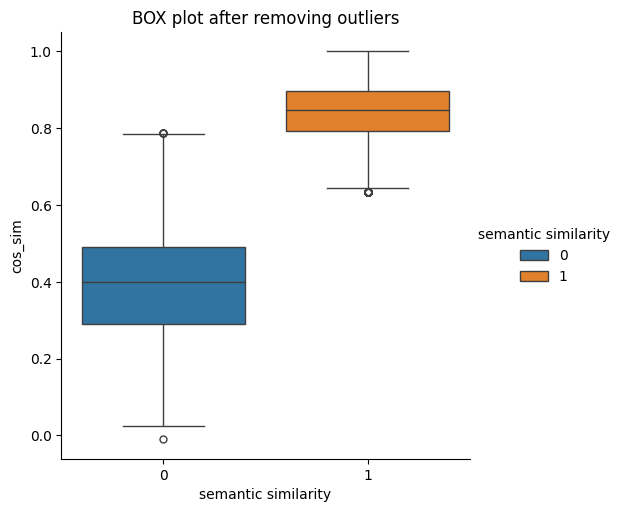

In [ ]:
sns.catplot(data=final_df,x='semantic similarity',y='cos_sim',kind='box',hue='semantic similarity')
plt.title('BOX plot after removing outliers')

# Model accuracy without custom features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
X=np.array(final_df['cos_sim'].tolist())
y=final_df['semantic similarity']



In [ ]:
X=X.reshape(-1,1)



In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)


In [ ]:
clf=RandomForestClassifier(n_estimators=50, random_state=42,max_depth=5)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)

In [ ]:
accuracy

0.949748743718593

In [ ]:
logic=LogisticRegression(C=0.002)
logic.fit(X_train,y_train)

LogisticRegression(C=0.002)

In [ ]:
y_pred=logic.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.914572864321608

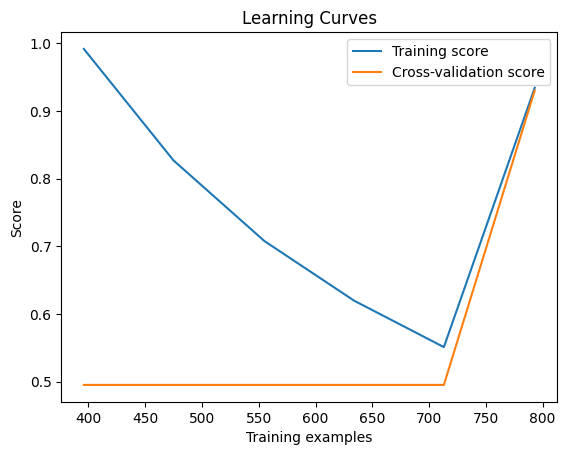

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(logic, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[89, 17],
       [ 0, 93]])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

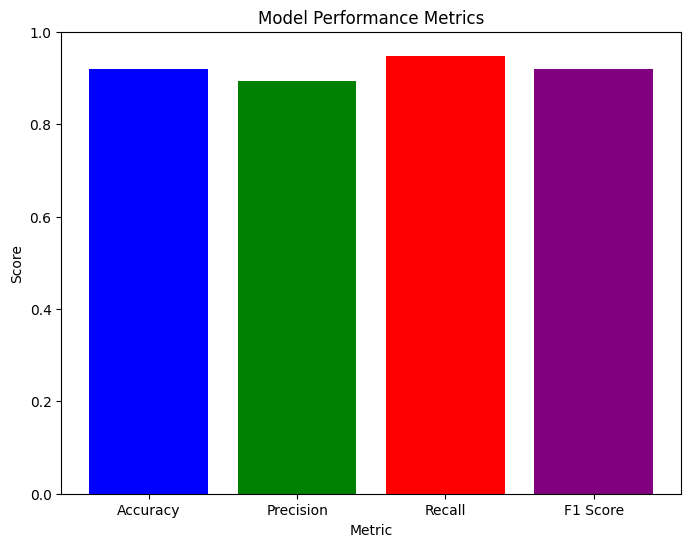

In [ ]:
# Metrics
metrics = [0.9196, 0.8932, 0.9485, 0.9201]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(metric_names, metrics, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.show()


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = np.asarray([[2250,  300],[250, 2200]])

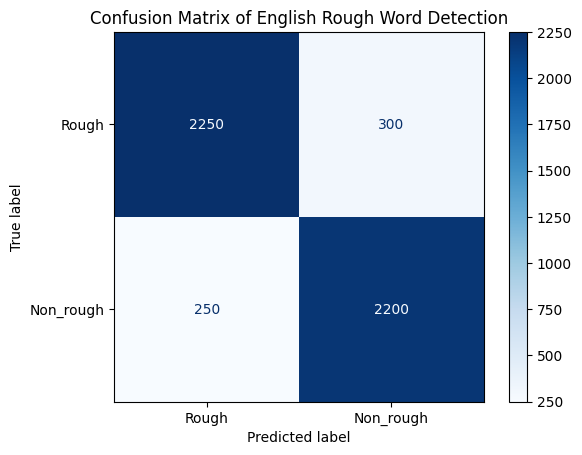

<Figure size 800x500 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Rough', 'Non_rough'])
disp.plot(cmap=plt.cm.Blues)

# Add a title and show the plot
plt.title("Confusion Matrix of English Rough Word Detection")
plt.figure(figsize=(8,5))
plt.show()

# Some Basic features

In [ ]:
temp_df=final_df[['semantic similarity','cos_sim']]

In [ ]:
# 1-> length  of the compalint
temp_df['comp1-len']=final_df['complaint-1'].str.len()
temp_df['comp2-len']=final_df['complaint-2'].str.len()

In [ ]:
# 2. -> number of words on the complaint
temp_df['comp1_num_words']=final_df['complaint-1'].apply(lambda x: len(x.split(" ")))
temp_df['comp2-num-words']=final_df['complaint-2'].apply(lambda x: len(x.split(" ")))

In [ ]:
# 3.-> word_common
def common_words(row):
  w1=set(map(lambda x: x.strip(),row['complaint-1'].split(" ")))
  w2=set(map(lambda x: x.strip(),row['complaint-2'].split(" ")))
  common_words=len(w1&w2)
  return common_words

In [ ]:
temp_df['common_words']=final_df.apply(common_words,axis=1)


In [ ]:
def total_words(row):
    w1 = set(map(lambda word: word.strip(), row['complaint-1'].split(" ")))
    w2 = set(map(lambda word: word.strip(), row['complaint-1'].split(" ")))
    return (len(w1) + len(w2))

In [ ]:
temp_df['total_words']=final_df.apply(total_words,axis=1)

In [ ]:
# 4.-> word share
temp_df['word_share'] = round(temp_df['common_words']/temp_df['total_words'],2)

In [ ]:

temp_df


,semantic similarity,cos_sim,comp1-len,comp2-len,comp1_num_words,comp2-num-words,common_words,total_words,word_share
0,1,0.710441,89,80,13,11,4,26,0.15
1,0,0.319354,171,166,30,26,4,54,0.07
2,1,0.678920,107,120,15,17,6,30,0.20
3,0,0.522505,138,146,21,21,5,40,0.12
4,0,0.488194,61,105,11,17,2,20,0.10
...,...,...,...,...,...,...,...,...,...
987,0,0.418629,81,104,12,13,5,24,0.21
988,0,0.354044,149,140,27,20,5,46,0.11
989,1,0.622616,103,118,15,18,6,30,0.20
990,1,0.698728,171,158,28,25,12,50,0.24


# performing EDA on Baic Features

In [ ]:
corr_data=temp_df.iloc[:,1:]

In [ ]:
mask=np.zeros_like(corr_data.corr())
triangle_indices=np.triu_indices_from(mask)
mask[triangle_indices]=True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

<Figure size 1200x500 with 0 Axes>

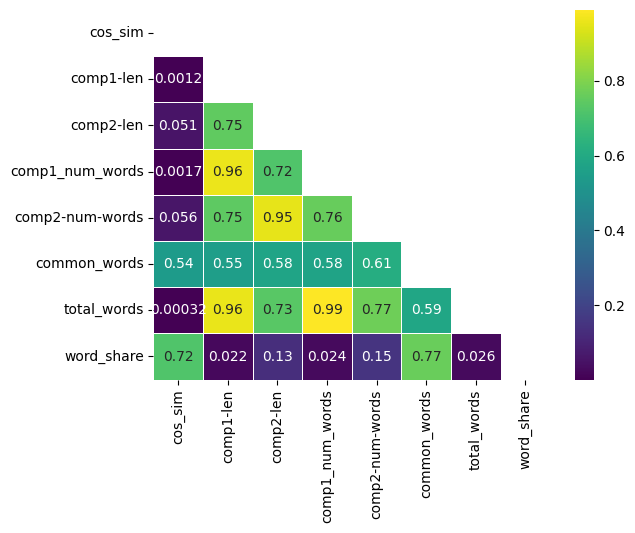

<Figure size 1200x500 with 0 Axes>

In [ ]:
sns.heatmap(corr_data.corr(),mask=mask,annot=True, linewidth=0.7,cmap='viridis')
plt.figure(figsize=(12,5))

# More Advance Features
1. Token Features
2. Lenght Features
3. Fuzzy Features

In [ ]:
def fetch_token_features(row):
  comp1=row['complaint-1']
  comp2=row['complaint-2']

  SAFE_DIV=0.0001
  STOP_WORDS=stopwords.words('english')

  token_features=[0.0]*8

  comp1_tokens=comp1.split(" ")
  comp2_tokens=comp2.split(" ")

  if len(comp1_tokens)==0 or len(comp2_tokens)==0:
    return token_features

  # get non-stopwords in the compliant
  comp1_words=set([word for word in comp1_tokens if word not in STOP_WORDS])
  comp2_words=set([word for word in comp2_tokens if word not in STOP_WORDS])

  # get the stopwords in the complaints
  comp1_stop=set([word for word in comp1_tokens if word in STOP_WORDS])
  comp2_stop=set([word for word in comp2_tokens if word in STOP_WORDS])

  # get common non_stopwords
  common_word_count=len(comp1_words.intersection(comp2_words))

  # get common non_stopwords
  common_stop_count=len(comp1_stop.intersection(comp2_stop))

  # get common tokens from complaint pairs
  common_token_count=len(set(comp1_tokens).intersection(set(comp2_tokens)))


  token_features[0]=common_word_count/(min(len(comp1_words),len(comp2_words))+SAFE_DIV)
  token_features[1]=common_word_count/(max(len(comp1_words),len(comp2_words))+SAFE_DIV)

  token_features[2]=common_stop_count/(min(len(comp1_stop),len(comp2_stop))+SAFE_DIV)
  token_features[3]=common_stop_count/(max(len(comp1_stop),len(comp2_stop))+SAFE_DIV)

  token_features[4]=common_token_count/(min(len(comp1_tokens),len(comp2_tokens)+SAFE_DIV))
  token_features[5]=common_token_count/(max(len(comp1_tokens),len(comp2_tokens))+SAFE_DIV)

  # last word of the both compliant is same or not
  token_features[6]=int(comp1_tokens[-1]==comp2_tokens[-1])

  #first word of the both complaint is same or not
  token_features[7]=int(comp1_tokens[0]==comp2_tokens[0])

  return token_features


In [ ]:
token_features = final_df.apply(fetch_token_features, axis=1)

temp_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
temp_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
temp_df["csc_min"]       = list(map(lambda x: x[2], token_features))
temp_df["csc_max"]       = list(map(lambda x: x[3], token_features))
temp_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
temp_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
temp_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
temp_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [ ]:
temp_df

,semantic similarity,cos_sim,comp1-len,comp2-len,comp1_num_words,comp2-num-words,common_words,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,1,0.710441,89,80,13,11,4,26,0.15,0.285710,0.285710,0.499988,0.333328,0.363633,0.307690,0,0
1,1,0.678920,107,120,15,17,6,30,0.20,0.333330,0.333330,0.499992,0.374995,0.400000,0.352939,0,0
2,1,0.707969,91,96,14,15,5,28,0.18,0.111110,0.111110,0.799984,0.666656,0.357143,0.333331,0,1
3,1,0.818945,96,93,17,18,6,32,0.19,0.499992,0.299997,0.499992,0.272725,0.352941,0.333331,1,1
4,1,0.808788,120,104,18,17,5,32,0.16,0.142855,0.099999,0.666656,0.499994,0.294116,0.277776,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,0.518214,97,227,18,42,4,30,0.13,0.111110,0.052631,0.499992,0.176470,0.222222,0.095238,0,0
988,0,0.232946,77,98,13,13,0,26,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
989,0,0.393367,72,74,12,9,1,22,0.05,0.000000,0.000000,0.499975,0.166664,0.111110,0.083333,0,0
990,0,0.418629,81,104,12,13,5,24,0.21,0.249997,0.222220,0.749981,0.749981,0.416667,0.384612,0,1


In [ ]:
corr_data=temp_df.iloc[:,1:-2]

In [ ]:
mask=np.zeros_like(corr_data.corr())
triangle_indices=np.triu_indices_from(mask)
mask[triangle_indices]=True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

<Axes: >

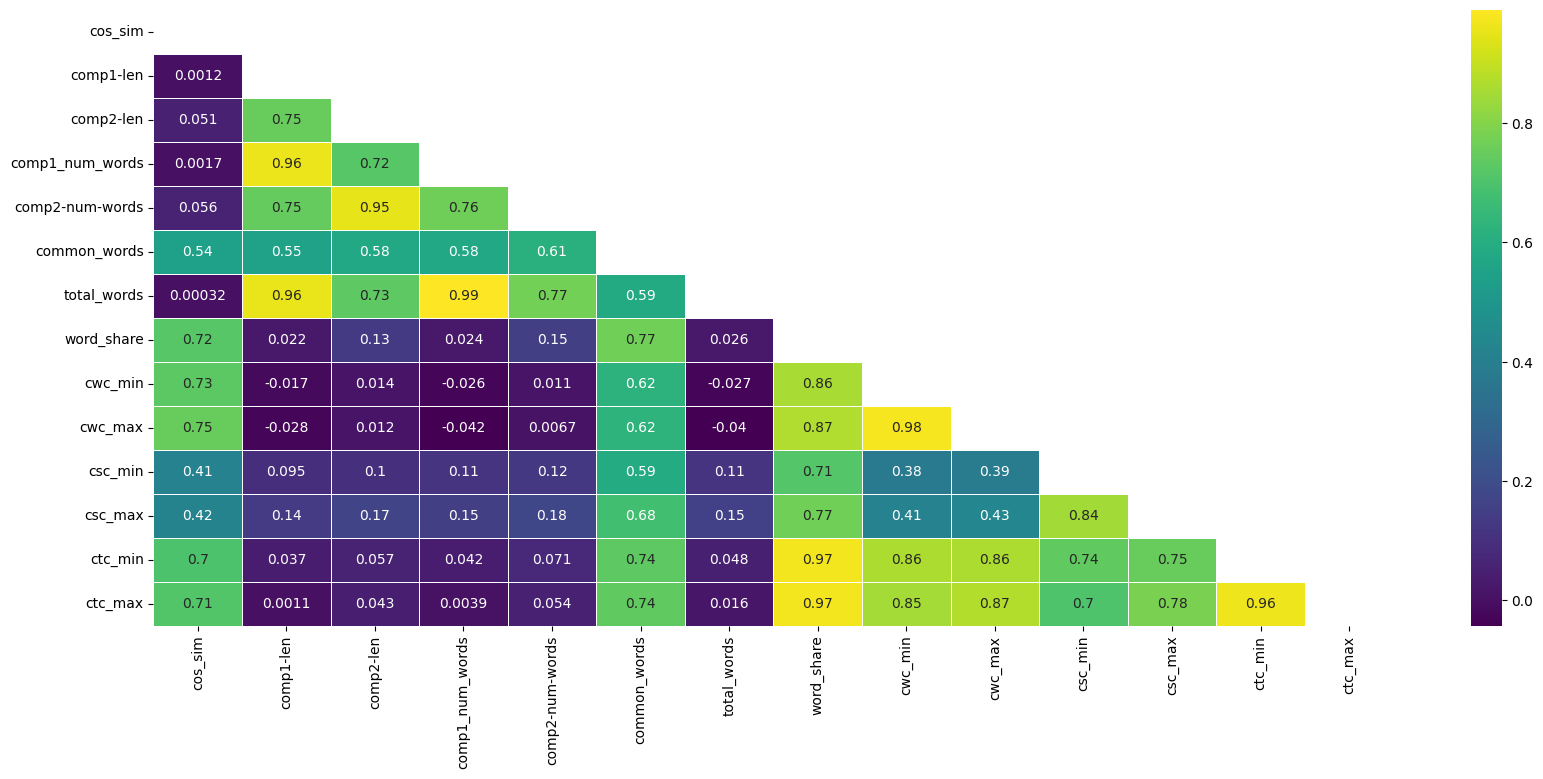

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(data=corr_data.corr(),mask=mask,annot=True,linewidth=0.5,cmap='viridis')



# Adding fuzzy features

In [ ]:
def fetch_fuzzy_features(row):

    comp1 = row['complaint-1']
    comp2 = row['complaint-2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(comp1, comp2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(comp1, comp2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(comp1, comp2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(comp1, comp2)

    return fuzzy_features

In [ ]:
fuzzy_features = final_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
temp_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
temp_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
temp_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
temp_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [ ]:
temp_df

,semantic similarity,cos_sim,comp1-len,comp2-len,comp1_num_words,comp2-num-words,common_words,total_words,word_share,cwc_min,...,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,1,0.710441,89,80,13,11,4,26,0.15,0.285710,...,0.499988,0.333328,0.363633,0.307690,0,0,65,80,79,81
1,1,0.678920,107,120,15,17,6,30,0.20,0.333330,...,0.499992,0.374995,0.400000,0.352939,0,0,48,59,46,52
2,1,0.707969,91,96,14,15,5,28,0.18,0.111110,...,0.799984,0.666656,0.357143,0.333331,0,1,53,52,42,50
3,1,0.818945,96,93,17,18,6,32,0.19,0.499992,...,0.499992,0.272725,0.352941,0.333331,1,1,48,53,64,57
4,1,0.808788,120,104,18,17,5,32,0.16,0.142855,...,0.666656,0.499994,0.294116,0.277776,0,0,36,38,59,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,0.518215,97,227,18,42,4,30,0.13,0.111110,...,0.499992,0.176470,0.222222,0.095238,0,0,5,33,6,31
988,0,0.232946,77,98,13,13,0,26,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,0,27,31,29,29
989,0,0.393367,72,74,12,9,1,22,0.05,0.000000,...,0.499975,0.166664,0.111110,0.083333,0,0,42,43,38,38
990,0,0.418629,81,104,12,13,5,24,0.21,0.249997,...,0.749981,0.749981,0.416667,0.384612,0,1,49,53,43,50


In [ ]:
corr_data=temp_df[['cos_sim','fuzz_ratio','fuzz_partial_ratio','token_sort_ratio','token_set_ratio']]

In [ ]:
mask=np.zeros_like(corr_data.corr())
triangle_indices=np.triu_indices_from(mask)
mask[triangle_indices]=True
mask

array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]])

<Axes: >

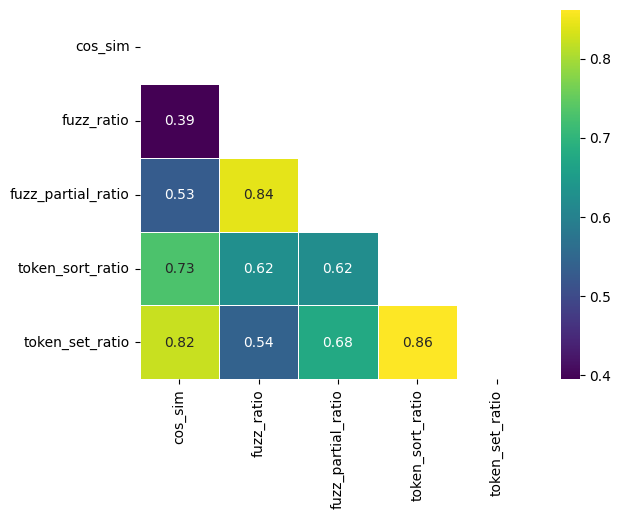

In [ ]:

sns.heatmap(data=corr_data.corr(),mask=mask,annot=True,linewidth=0.5,cmap='viridis')

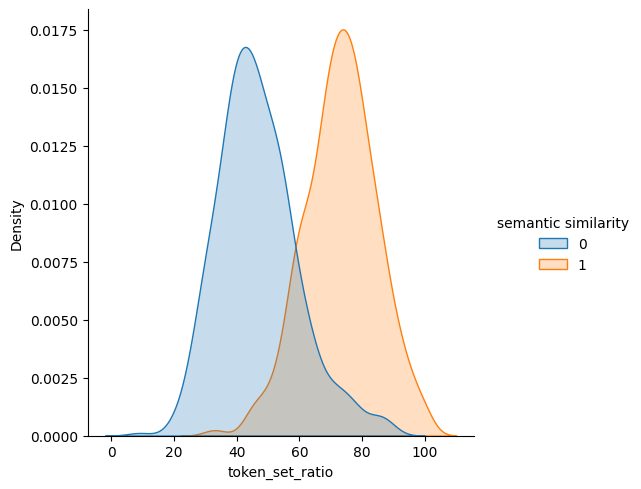

In [ ]:
sns.displot(data=temp_df,x='token_set_ratio',hue='semantic similarity',kind='kde', fill=True)

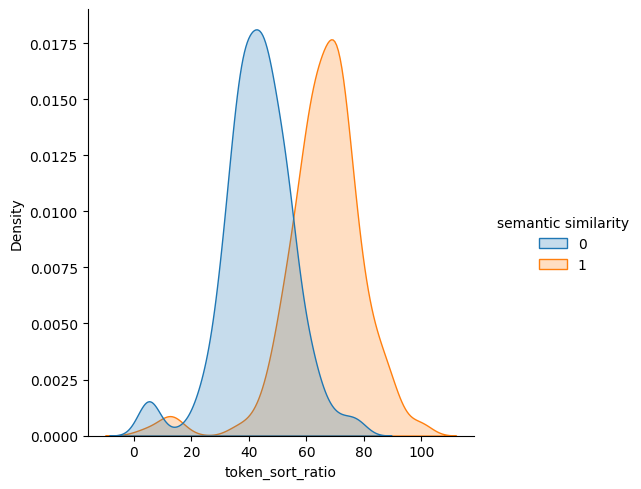

In [ ]:
sns.displot(data=temp_df,x='token_sort_ratio',hue='semantic similarity',kind='kde',fill=True)

In [ ]:
temp_df

,semantic similarity,cos_sim,comp1-len,comp2-len,comp1_num_words,comp2-num-words,common_words,total_words,word_share,cwc_min,...,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,1,0.710441,89,80,13,11,4,26,0.15,0.285710,...,0.499988,0.333328,0.363633,0.307690,0,0,65,80,79,81
1,1,0.678920,107,120,15,17,6,30,0.20,0.333330,...,0.499992,0.374995,0.400000,0.352939,0,0,48,59,46,52
2,1,0.707969,91,96,14,15,5,28,0.18,0.111110,...,0.799984,0.666656,0.357143,0.333331,0,1,53,52,42,50
3,1,0.818945,96,93,17,18,6,32,0.19,0.499992,...,0.499992,0.272725,0.352941,0.333331,1,1,48,53,64,57
4,1,0.808788,120,104,18,17,5,32,0.16,0.142855,...,0.666656,0.499994,0.294116,0.277776,0,0,36,38,59,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,0.518215,97,227,18,42,4,30,0.13,0.111110,...,0.499992,0.176470,0.222222,0.095238,0,0,5,33,6,31
988,0,0.232946,77,98,13,13,0,26,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,0,27,31,29,29
989,0,0.393367,72,74,12,9,1,22,0.05,0.000000,...,0.499975,0.166664,0.111110,0.083333,0,0,42,43,38,38
990,0,0.418629,81,104,12,13,5,24,0.21,0.249997,...,0.749981,0.749981,0.416667,0.384612,0,1,49,53,43,50


# Mutual Information Gain

In [ ]:
X=temp_df.iloc[:,1:]
y=temp_df['semantic similarity']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
# determining the mutual information
mutual_info=mutual_info_classif(X_train,y_train)
mutual_info

array([0.58533166, 0.        , 0.01078237, 0.        , 0.        ,
       0.19773396, 0.03441976, 0.26575623, 0.2536537 , 0.28331248,
       0.10316444, 0.1562036 , 0.26642603, 0.30279656, 0.03700988,
       0.05849513, 0.06242034, 0.11972006, 0.3458764 , 0.38583255])

In [ ]:
mutual_info=pd.Series(mutual_info)
mutual_info.index=X_train.columns
mutual_info

cos_sim               0.585332
comp1-len             0.000000
comp2-len             0.010782
comp1_num_words       0.000000
comp2-num-words       0.000000
common_words          0.197734
total_words           0.034420
word_share            0.265756
cwc_min               0.253654
cwc_max               0.283312
csc_min               0.103164
csc_max               0.156204
ctc_min               0.266426
ctc_max               0.302797
last_word_eq          0.037010
first_word_eq         0.058495
fuzz_ratio            0.062420
fuzz_partial_ratio    0.119720
token_sort_ratio      0.345876
token_set_ratio       0.385833
dtype: float64

In [ ]:
mutual_info=mutual_info.sort_values(ascending=False)
mutual_info

cos_sim               0.585332
token_set_ratio       0.385833
token_sort_ratio      0.345876
ctc_max               0.302797
cwc_max               0.283312
ctc_min               0.266426
word_share            0.265756
cwc_min               0.253654
common_words          0.197734
csc_max               0.156204
fuzz_partial_ratio    0.119720
csc_min               0.103164
fuzz_ratio            0.062420
first_word_eq         0.058495
last_word_eq          0.037010
total_words           0.034420
comp2-len             0.010782
comp1_num_words       0.000000
comp1-len             0.000000
comp2-num-words       0.000000
dtype: float64

In [ ]:
cols=mutual_info.index
cols

Index(['cos_sim', 'token_set_ratio', 'token_sort_ratio', 'ctc_max', 'cwc_max',
       'ctc_min', 'word_share', 'cwc_min', 'common_words', 'csc_max',
       'fuzz_partial_ratio', 'csc_min', 'fuzz_ratio', 'first_word_eq',
       'last_word_eq', 'total_words', 'comp2-len', 'comp1_num_words',
       'comp1-len', 'comp2-num-words'],
      dtype='object')

In [ ]:
cols=cols[0:3]
cols


Index(['cos_sim', 'token_set_ratio', 'token_sort_ratio'], dtype='object')

In [ ]:
X=temp_df[cols]
X=np.asarray(X)
# X=X.reshape(-1,1)
y=temp_df['semantic similarity']

In [ ]:
X

array([[ 0.71044099, 81.        , 79.        ],
       [ 0.31935358, 45.        , 40.        ],
       [ 0.67891967, 52.        , 46.        ],
       ...,
       [ 0.62261647, 60.        , 50.        ],
       [ 0.69872773, 65.        , 59.        ],
       [ 0.82232386, 69.        , 13.        ]])

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)


In [ ]:
clf=RandomForestClassifier(n_estimators=50,max_depth=None,min_samples_leaf= 1, min_samples_split=10,random_state=42)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)

In [ ]:
accuracy

0.9195979899497487

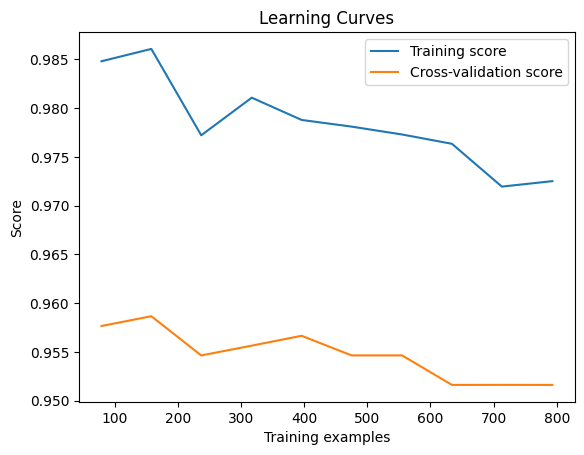

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


In [ ]:
train_sizes

array([ 79, 158, 237, 317, 396, 475, 555, 634, 713, 793])

In [ ]:
train_scores

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.98989899, 0.99242424, 0.99242424, 0.99242424, 0.99242424],
       [0.99368421, 0.99157895, 0.99157895, 0.99157895, 0.99157895],
       [0.98918919, 0.98558559, 0.98738739, 0.98738739, 0.98738739],
       [0.9873817 , 0.98580442, 0.9873817 , 0.98422713, 0.98895899],
       [0.98316971, 0.98316971, 0.98176718, 0.98316971, 0.98457223],
       [0.98360656, 0.98360656, 0.98234552, 0.98612863, 0.98612863]])

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [30,40,50,60],
    'max_depth': [None, 10, 20, 30,],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


clf = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


In [ ]:
grid_search.best_score_

0.9672239471379667

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Confusion Matrix:
 [[91 11]
 [ 5 92]]
Precision: 0.8932038834951457
Recall: 0.9484536082474226


# Query point creator

In [ ]:
def query_point(comp1,comp2):
  STOP_WORDS=stopwords.words('english')
  SAFE_DIV=0.0001
  comp1_tokens=comp1.lower().strip().split(" ")
  comp2_tokens=comp2.lower().strip().split(" ")

  comp1_processed=remove_stopwords(preprocessing(comp1))
  comp2_processed=remove_stopwords(preprocessing(comp2))

  emb1=model.encode(comp1_processed,convert_to_tensor=True)
  emb2=model.encode(comp2_processed,convert_to_tensor=True)

  cos_sim=util.cos_sim(emb1,emb2)[0,0]
  # cos_sim=model.similarity(emb1, emb2)[0,0]

  # token_set_ratio
  token_set_ratio=fuzz.token_set_ratio(comp1,comp2)
  # token_sort_ratio
  token_sort_ratio=fuzz.token_sort_ratio(comp1,comp2)


  comp1_words = set([word for word in comp1_tokens if word not in STOP_WORDS])
  comp2_words = set([word for word in comp1_tokens if word not in STOP_WORDS])

  comp1_stops = set([word for word in comp1_tokens if word in STOP_WORDS])
  comp2_stops = set([word for word in comp2_tokens if word in STOP_WORDS])

  common_word_count = len(comp1_words.intersection(comp2_words))


  common_stop_count = len(comp1_stops.intersection(comp2_stops))

  common_token_count = len(set(comp1_tokens).intersection(set(comp2_tokens)))

# ctc_max
  ctc_max= common_token_count / (max(len(comp1_tokens), len(comp2_tokens)) + SAFE_DIV)
#ctc_min
  ctc_min= common_token_count / (min(len(comp1_tokens), len(comp2_tokens)) + SAFE_DIV)

  # cwc_max
  cwc_max=  common_word_count / (max(len(comp1_words), len(comp2_words)) + SAFE_DIV)
 #cwc_min
  cwc_min= common_word_count / (min(len(comp1_words), len(comp2_words)) + SAFE_DIV)

  # csc_max
  csc_max=common_stop_count / (max(len(comp1_stops), len(comp2_stops)) + SAFE_DIV)


  # word_share
  w1=set(comp1_tokens)
  w2=set(comp2_tokens)
  common_words=len(w1&w2)

  total_words=len(w1)+len(w2)
  word_share = round(common_words/total_words,2)


  return cos_sim,token_set_ratio,token_sort_ratio,ctc_max,word_share,ctc_min,cwc_max,cwc_min,common_words,csc_max


In [ ]:
sen1='I am frustrated with the sluggish internet connection from your company'
sen2="I find your company's slow internet connection to be annoying."


In [ ]:
sen1="The service took much longer than expected. I had to wait for over an hour, which was quite frustrating as I had other commitments. This kind of delay is unacceptable and needs to be addressed."
sen2="I was really disappointed with the delay; the service should have been quicker. I spent an excessive amount of time waiting, which disrupted my schedule. Improvements in efficiency are clearly needed."

In [ ]:
sen1='Water in the second floor is finishing too quickly'
sen2=" Quality of the water in the second floor is not good"
# sen2='ther is no enough water in the second floor'

In [ ]:
# sen1='The library is always too crowded, making it difficult to find a quiet place to study.'
sen2='In library,Many of the books I need are often checked out or unavailable.'
sen1="Books in the library are outdated and they are not releated with our syallbus"


In [ ]:
sen1='officers are not responding quickly'
sen2='There are not enough officer to server the citizens'

In [ ]:
sen1='water is not clean'
sen2='water is finishing quickly'

In [ ]:

query=query_point(sen1,sen2)[0:3]

In [ ]:
query

(tensor(0.7603, device='cuda:0'), 72, 67)

In [ ]:
cos_sim=query[0].cpu()
token_set_ratio=query[1]
token_sort_ratio=query[2]

token_sort_ratio

50

In [ ]:
query=np.array([cos_sim,token_set_ratio,token_sort_ratio])
# query=np.array([0.67,90,80])

query=query.reshape(1,-1)

In [ ]:
query

array([[ 0.47136655, 62.        , 50.        ]])

In [ ]:
clf.predict(query)[0]



0

In [ ]:
query

array([[0.76026595]], dtype=float32)

In [ ]:
sen1=remove_stopwords(preprocessing(sen1))
sen2=remove_stopwords(preprocessing(sen2))


In [ ]:
emb1=model1.encode(sen1)
emb2=model1.encode(sen2)

In [ ]:
cos_sim=util.cos_sim(emb1,emb2)

In [ ]:
cos_sim

In [ ]:
import pickle

In [ ]:
model.save('Transformer')

In [ ]:
import shutil
import os

# Replace 'your_folder' with your actual folder name
source = '/content/Transformer'
destination = '/content/drive/MyDrive/Transformer'

# If the destination folder already exists, remove it first
if os.path.exists(destination):
    shutil.rmtree(destination)

shutil.copytree(source, destination)


'/content/drive/MyDrive/Transformer'

In [ ]:
import pickle

model_filename = 'semantic_classifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(clf, file)


In [ ]:
import pickle

# Load the model with the specified filename
model_filename = '/content/semantic_classifier.pkl'
with open(model_filename, 'rb') as file:
    loaded_clf = pickle.load(file)


1.3.2


'so'